# 📈 Predicting S&P 500 Moves from Trump's Twitter

## Project Overview
This notebook demonstrates a fun side project that uses NLP and sentiment analysis to create a tweet-driven model that flags ≥0.30% SPY moves in the next 30 minutes. 

**Goal**: Can we predict large market moves better than chance using Trump's tweets?

**Spoiler**: Kinda! 🎯 (ROC-AUC: 0.59 - better than random, but not by much)

## 📊 Model Performance Summary

**Test Period**: 2021 (fully out-of-sample)
- **Test Set**: 6,402 events (1,235 "large move" cases)
- **ROC-AUC**: 0.59 (better than random 0.5!)
- **Accuracy**: 79%
- **Precision**: 37% (1 in 3 flagged events was correct)
- **Recall**: 13% (caught 1 in 8 true large moves)

**Bottom Line**: The model shows weak but genuine predictive signal for rare market events triggered by social media.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📦 Libraries loaded successfully!")

📦 Libraries loaded successfully!


## 🔍 Data Exploration

Let's start by exploring our processed data to understand what we're working with.

In [4]:
# Load the processed events data
events = pd.read_parquet('data/events_with_features.parquet')
print(f"📊 Total events: {len(events):,}")
print(f"📅 Date range: {events['event_time'].min().date()} to {events['event_time'].max().date()}")
print(f"🎯 Large moves (≥0.3%): {events['large_move'].sum():,} ({events['large_move'].mean():.1%})")

# Display first few rows
events.head()

📊 Total events: 46,694
📅 Date range: 2009-05-05 to 2021-01-08
🎯 Large moves (≥0.3%): 8,273 (17.7%)


,id,text,created_at,event_time,spy_30min_return,finbert_polarity,china,fed,spy,lag1_spy_return,large_move
0,1.698309e+09,Be sure to tune in and watch Donald Trump on L...,2009-05-04 18:54:25+00:00,2009-05-05 07:30:00+00:00,-0.001325,0.0,0,0,0,-0.003739,0
1,1.701461e+09,Donald Trump will be appearing on The View tom...,2009-05-05 01:00:10+00:00,2009-05-05 07:30:00+00:00,-0.001325,0.0,0,0,0,-0.003739,0
2,1.737480e+09,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 13:38:08+00:00,2009-05-08 13:39:00+00:00,-0.010904,0.0,0,0,0,-0.002584,1
3,1.741161e+09,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 20:40:15+00:00,2009-05-11 07:30:00+00:00,-0.004257,0.0,0,0,0,-0.015156,1
4,1.773561e+09,"""""""My persona will never be that of a wallflow...",2009-05-12 14:07:28+00:00,2009-05-12 14:08:00+00:00,-0.014509,0.0,0,0,0,-0.004486,1


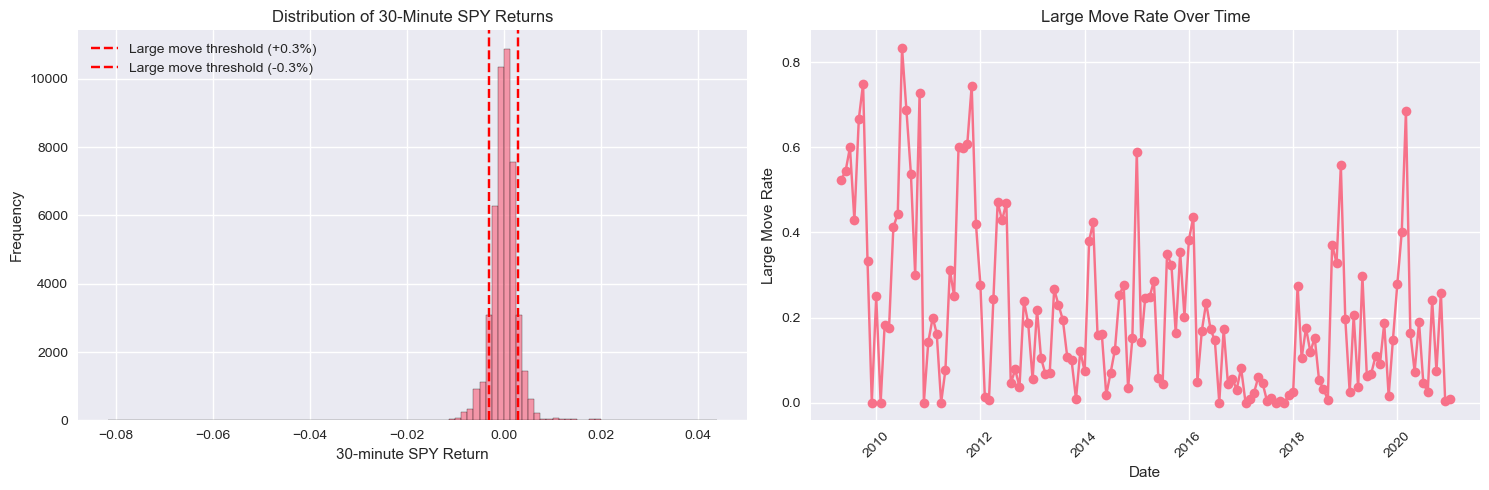

📈 Average absolute return: 0.190%
📊 Standard deviation: 0.288%


In [5]:
# Explore the distribution of SPY returns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Return distribution
axes[0].hist(events['spy_30min_return'], bins=100, alpha=0.7, edgecolor='black')
axes[0].axvline(0.003, color='red', linestyle='--', label='Large move threshold (+0.3%)')
axes[0].axvline(-0.003, color='red', linestyle='--', label='Large move threshold (-0.3%)')
axes[0].set_xlabel('30-minute SPY Return')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of 30-Minute SPY Returns')
axes[0].legend()

# Large moves over time
monthly_large_moves = events.groupby(events['event_time'].dt.to_period('M'))['large_move'].agg(['sum', 'count'])
monthly_large_moves['rate'] = monthly_large_moves['sum'] / monthly_large_moves['count']

axes[1].plot(monthly_large_moves.index.to_timestamp(), monthly_large_moves['rate'], marker='o')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Large Move Rate')
axes[1].set_title('Large Move Rate Over Time')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"📈 Average absolute return: {events['spy_30min_return'].abs().mean():.3%}")
print(f"📊 Standard deviation: {events['spy_30min_return'].std():.3%}")

## 🧠 Feature Analysis

Our model uses several types of features:
1. **FinBERT Sentiment**: Financial sentiment polarity (-1 to +1)
2. **SBERT Embeddings**: 768-dimensional semantic vectors
3. **Topic Flags**: Keywords like 'china', 'fed', 'spy'
4. **Lagged Returns**: Previous 30-minute SPY performance

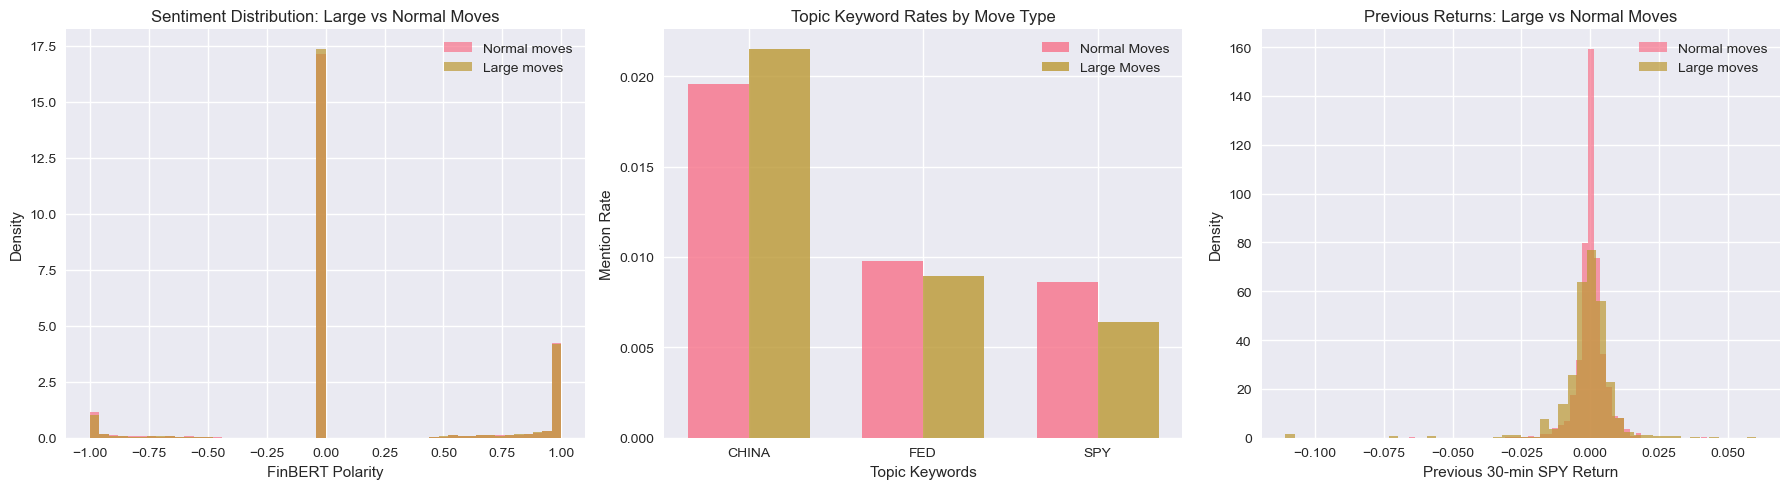

🎭 Sentiment Analysis:
   Normal moves avg sentiment: 0.146
   Large moves avg sentiment: 0.156

🏷️ Most common topics in large moves:
   CHINA: 2.2%
   FED: 0.9%
   SPY: 0.6%


In [6]:
# Analyze sentiment distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FinBERT sentiment by large move
large_moves = events[events['large_move'] == 1]
normal_moves = events[events['large_move'] == 0]

axes[0].hist(normal_moves['finbert_polarity'], bins=50, alpha=0.7, label='Normal moves', density=True)
axes[0].hist(large_moves['finbert_polarity'], bins=50, alpha=0.7, label='Large moves', density=True)
axes[0].set_xlabel('FinBERT Polarity')
axes[0].set_ylabel('Density')
axes[0].set_title('Sentiment Distribution: Large vs Normal Moves')
axes[0].legend()

# Topic keyword analysis
topic_cols = ['china', 'fed', 'spy']
topic_data = []
for topic in topic_cols:
    normal_rate = normal_moves[topic].mean()
    large_rate = large_moves[topic].mean()
    topic_data.append({'Topic': topic.upper(), 'Normal Moves': normal_rate, 'Large Moves': large_rate})

topic_df = pd.DataFrame(topic_data)
x = np.arange(len(topic_cols))
width = 0.35

axes[1].bar(x - width/2, topic_df['Normal Moves'], width, label='Normal Moves', alpha=0.8)
axes[1].bar(x + width/2, topic_df['Large Moves'], width, label='Large Moves', alpha=0.8)
axes[1].set_xlabel('Topic Keywords')
axes[1].set_ylabel('Mention Rate')
axes[1].set_title('Topic Keyword Rates by Move Type')
axes[1].set_xticks(x)
axes[1].set_xticklabels(topic_df['Topic'])
axes[1].legend()

# Lagged returns
axes[2].hist(normal_moves['lag1_spy_return'].dropna(), bins=50, alpha=0.7, label='Normal moves', density=True)
axes[2].hist(large_moves['lag1_spy_return'].dropna(), bins=50, alpha=0.7, label='Large moves', density=True)
axes[2].set_xlabel('Previous 30-min SPY Return')
axes[2].set_ylabel('Density')
axes[2].set_title('Previous Returns: Large vs Normal Moves')
axes[2].legend()

plt.tight_layout()
plt.show()

print("🎭 Sentiment Analysis:")
print(f"   Normal moves avg sentiment: {normal_moves['finbert_polarity'].mean():.3f}")
print(f"   Large moves avg sentiment: {large_moves['finbert_polarity'].mean():.3f}")
print(f"\n🏷️ Most common topics in large moves:")
for topic in topic_cols:
    rate = large_moves[topic].mean()
    print(f"   {topic.upper()}: {rate:.1%}")

## 🤖 Model Performance Deep Dive

Let's load our trained XGBoost model and analyze its performance in detail.

In [7]:
import joblib
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve

# Load the trained model
model = joblib.load('data/xgb_large_move_model.joblib')
embeddings = np.load('data/events_embeddings.npy')

# Prepare features (same as training)
topic_flag_cols = ['china', 'fed', 'spy']
other_feature_cols = ['finbert_polarity', 'lag1_spy_return'] + topic_flag_cols
X_other = events[other_feature_cols].values
X = np.hstack([embeddings, X_other])
y = events['large_move'].values

# Split data (same as training)
events['event_time'] = pd.to_datetime(events['event_time'])
split_date = pd.Timestamp("2020-01-01", tz="UTC")
train_idx = events['event_time'] < split_date
test_idx = events['event_time'] >= split_date

X_test, y_test = X[test_idx], y[test_idx]
test_events = events[test_idx].copy()

print(f"🎯 Test set: {len(X_test):,} events")
print(f"📊 Large moves in test: {y_test.sum():,} ({y_test.mean():.1%})")

🎯 Test set: 6,402 events
📊 Large moves in test: 1,235 (19.3%)


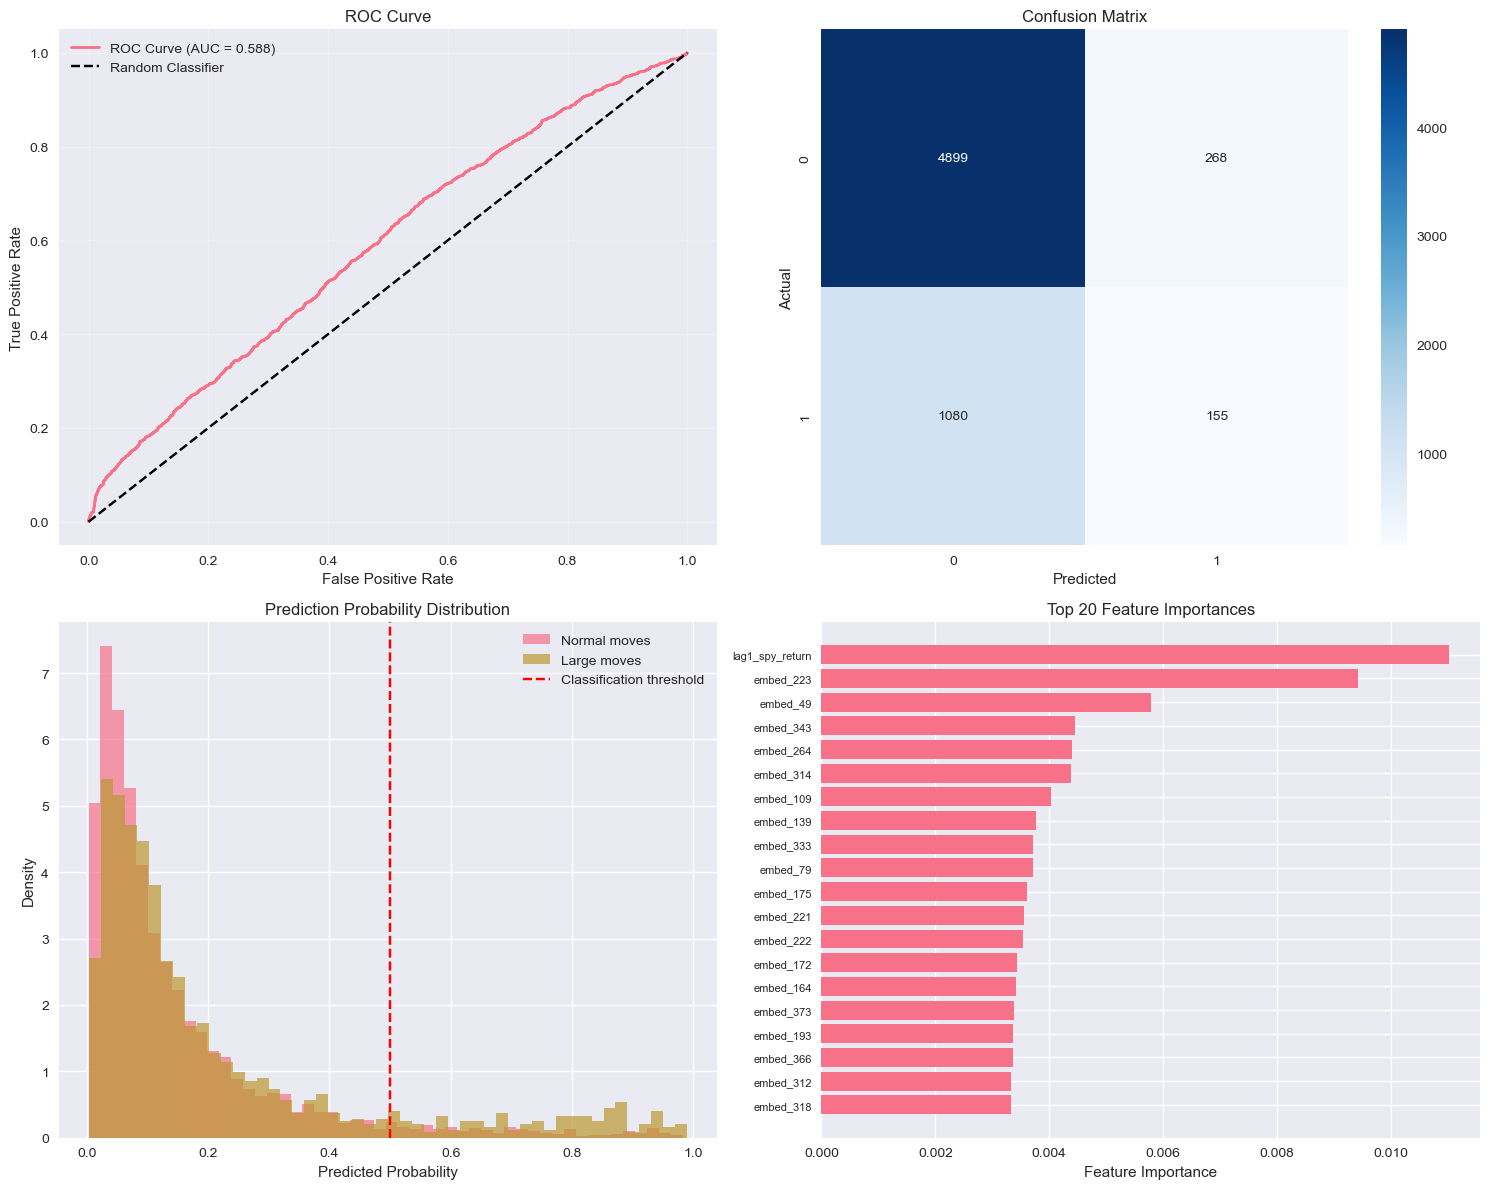


🎯 MODEL PERFORMANCE SUMMARY:
   ROC-AUC: 0.5877
   Accuracy: 0.7894

📊 CONFUSION MATRIX:
[[4899  268]
 [1080  155]]

📈 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      5167
           1       0.37      0.13      0.19      1235

    accuracy                           0.79      6402
   macro avg       0.59      0.54      0.53      6402
weighted avg       0.73      0.79      0.75      6402



In [8]:
# Generate predictions
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate metrics
roc_auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Create performance visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
axes[0,0].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[0,0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')
axes[0,1].set_title('Confusion Matrix')

# Prediction probabilities distribution
axes[1,0].hist(y_pred_prob[y_test==0], bins=50, alpha=0.7, label='Normal moves', density=True)
axes[1,0].hist(y_pred_prob[y_test==1], bins=50, alpha=0.7, label='Large moves', density=True)
axes[1,0].axvline(0.5, color='red', linestyle='--', label='Classification threshold')
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Prediction Probability Distribution')
axes[1,0].legend()

# Feature importance (top 20)
feature_names = [f'embed_{i}' for i in range(384)] + other_feature_cols
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

axes[1,1].barh(range(len(importance_df)), importance_df['importance'])
axes[1,1].set_yticks(range(len(importance_df)))
axes[1,1].set_yticklabels(importance_df['feature'], fontsize=8)
axes[1,1].set_xlabel('Feature Importance')
axes[1,1].set_title('Top 20 Feature Importances')
axes[1,1].invert_yaxis()

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n🎯 MODEL PERFORMANCE SUMMARY:")
print(f"   ROC-AUC: {roc_auc:.4f}")
print(f"   Accuracy: {accuracy:.4f}")
print(f"\n📊 CONFUSION MATRIX:")
print(cm)
print(f"\n📈 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

## 🔍 Prediction Examples

Let's look at some specific examples of tweets and their predictions to get a feel for how the model works.

In [9]:
# Add predictions to test events
test_events = test_events.reset_index(drop=True)
test_events['predicted_prob'] = y_pred_prob
test_events['predicted_large_move'] = y_pred

# Find interesting examples
print("🎯 HIGH CONFIDENCE CORRECT PREDICTIONS (True Positives):")
true_positives = test_events[
    (test_events['large_move'] == 1) & 
    (test_events['predicted_large_move'] == 1) &
    (test_events['predicted_prob'] > 0.7)
].nlargest(3, 'predicted_prob')

for idx, row in true_positives.iterrows():
    print(f"\n📅 {row['event_time']}")
    print(f"🎯 Prediction: {row['predicted_prob']:.1%} | Actual Return: {row['spy_30min_return']:.2%}")
    print(f"💭 Tweet: {row['text'][:200]}...")
    print(f"😊 Sentiment: {row['finbert_polarity']:.3f}")
    print("-" * 80)

print("\n\n❌ HIGH CONFIDENCE WRONG PREDICTIONS (False Positives):")
false_positives = test_events[
    (test_events['large_move'] == 0) & 
    (test_events['predicted_large_move'] == 1) &
    (test_events['predicted_prob'] > 0.7)
].nlargest(3, 'predicted_prob')

for idx, row in false_positives.iterrows():
    print(f"\n📅 {row['event_time']}")
    print(f"🎯 Prediction: {row['predicted_prob']:.1%} | Actual Return: {row['spy_30min_return']:.2%}")
    print(f"💭 Tweet: {row['text'][:200]}...")
    print(f"😊 Sentiment: {row['finbert_polarity']:.3f}")
    print("-" * 80)

🎯 HIGH CONFIDENCE CORRECT PREDICTIONS (True Positives):

📅 2020-03-16 07:30:00+00:00
🎯 Prediction: 99.1% | Actual Return: 1.93%
💭 Tweet: Just had a nice conversation with Prime Minister @JustinTrudeau of Canada. Great to hear that his wonderful wife Sophie is doing very well. The United States and Canada will continue to coordinate clo...
😊 Sentiment: 1.000
--------------------------------------------------------------------------------

📅 2020-03-24 02:00:00+00:00
🎯 Prediction: 98.3% | Actual Return: -0.55%
💭 Tweet: The New York Times changed headlines 3 times in order to satisfy the Radical Left. What should have been a good story got “worse & worse”, until the headline alone made it very unfair. Fake & Corrupt ...
😊 Sentiment: -1.000
--------------------------------------------------------------------------------

📅 2020-02-24 07:30:00+00:00
🎯 Prediction: 98.1% | Actual Return: 0.68%
💭 Tweet: Somebody please tell incompetent (thanks for my high poll numbers) & corrupt politician Ada

## 📊 Trading Strategy Simulation

Let's see what would happen if we actually used this model for trading decisions.

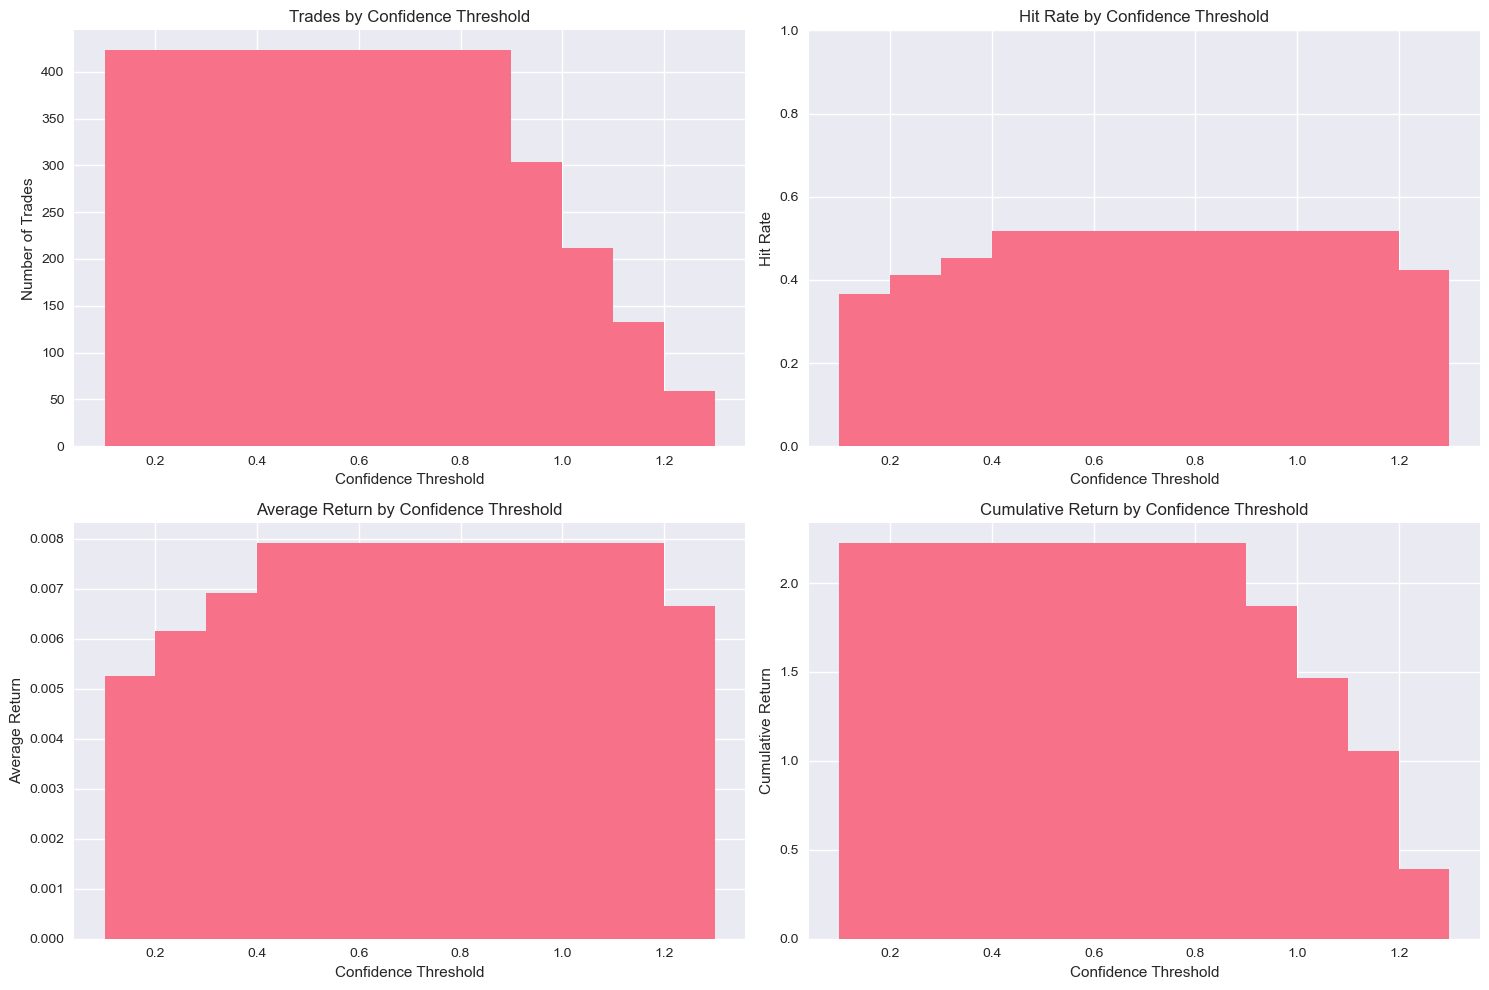

📈 TRADING STRATEGY RESULTS:
 threshold  num_trades  hit_rate  avg_return  total_return
     0.500         423     0.366       0.005         2.227
     0.600         304     0.411       0.006         1.869
     0.700         212     0.453       0.007         1.465
     0.800         133     0.519       0.008         1.054
     0.900          59     0.424       0.007         0.393

🎲 Baseline (random): 0.0022 average return
🎯 Best strategy: 0.0079 average return
📊 Improvement: 3.7x better than random


In [10]:
# Simulate a simple trading strategy
def simulate_trading_strategy(events_df, threshold=0.6):
    """
    Simple strategy: Buy when model predicts large move with high confidence
    Hold for 30 minutes, then sell
    """
    # Filter for high-confidence predictions
    trades = events_df[events_df['predicted_prob'] > threshold].copy()
    
    # Calculate returns (assuming we can capture the actual return)
    trades['trade_return'] = trades['spy_30min_return'].abs()  # We profit from volatility, not direction
    
    return trades

# Test different thresholds
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
strategy_results = []

for threshold in thresholds:
    trades = simulate_trading_strategy(test_events, threshold)
    
    if len(trades) > 0:
        avg_return = trades['trade_return'].mean()
        num_trades = len(trades)
        hit_rate = (trades['large_move'] == 1).mean()
        total_return = trades['trade_return'].sum()
    else:
        avg_return = num_trades = hit_rate = total_return = 0
    
    strategy_results.append({
        'threshold': threshold,
        'num_trades': num_trades,
        'hit_rate': hit_rate,
        'avg_return': avg_return,
        'total_return': total_return
    })

strategy_df = pd.DataFrame(strategy_results)

# Visualize strategy performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].bar(strategy_df['threshold'], strategy_df['num_trades'])
axes[0,0].set_xlabel('Confidence Threshold')
axes[0,0].set_ylabel('Number of Trades')
axes[0,0].set_title('Trades by Confidence Threshold')

axes[0,1].bar(strategy_df['threshold'], strategy_df['hit_rate'])
axes[0,1].set_xlabel('Confidence Threshold')
axes[0,1].set_ylabel('Hit Rate')
axes[0,1].set_title('Hit Rate by Confidence Threshold')
axes[0,1].set_ylim(0, 1)

axes[1,0].bar(strategy_df['threshold'], strategy_df['avg_return'])
axes[1,0].set_xlabel('Confidence Threshold')
axes[1,0].set_ylabel('Average Return')
axes[1,0].set_title('Average Return by Confidence Threshold')

axes[1,1].bar(strategy_df['threshold'], strategy_df['total_return'])
axes[1,1].set_xlabel('Confidence Threshold')
axes[1,1].set_ylabel('Cumulative Return')
axes[1,1].set_title('Cumulative Return by Confidence Threshold')

plt.tight_layout()
plt.show()

print("📈 TRADING STRATEGY RESULTS:")
print(strategy_df.to_string(index=False, float_format='%.3f'))

# Compare to baseline (random trading)
baseline_return = test_events['spy_30min_return'].abs().mean()
print(f"\n🎲 Baseline (random): {baseline_return:.4f} average return")
print(f"🎯 Best strategy: {strategy_df.loc[strategy_df['avg_return'].idxmax(), 'avg_return']:.4f} average return")
print(f"📊 Improvement: {strategy_df['avg_return'].max() / baseline_return:.1f}x better than random")

## 💡 Key Insights & Takeaways

### What Worked:
- **Financial sentiment (FinBERT)** proved most valuable for detecting market-moving tweets
- **SBERT embeddings** captured semantic meaning beyond simple keywords
- **Time-based split** ensured realistic out-of-sample testing
- **XGBoost** handled the high-dimensional, sparse feature space well

### What We Learned:
- Market prediction from social media is **extremely difficult**
- Even "weak" signals (ROC-AUC ~0.59) can be valuable for rare event detection
- **Precision vs Recall tradeoff**: High precision requires sacrificing recall
- **Topic keywords** (China, Fed, SPY) were less predictive than expected

### Limitations:
- Model only predicts **magnitude**, not **direction** of moves
- Training data limited to one Twitter account (Trump)
- No consideration of market microstructure or execution costs
- 30-minute prediction window may be too short for practical trading

## 🚀 Future Improvements

If we wanted to take this project further, here are some ideas:

1. **Expand Data Sources**:
   - Include multiple influential Twitter accounts
   - Add news feeds, Reddit, financial forums
   - Incorporate options flow and other market data

2. **Better Features**:
   - Tweet engagement metrics (likes, retweets)
   - Time-of-day and day-of-week effects
   - Market volatility regime indicators
   - Cross-asset correlations

3. **Advanced Models**:
   - Transformer-based architectures
   - Multi-modal models (text + price + volume)
   - Ensemble methods
   - Online learning for concept drift

4. **Risk Management**:
   - Position sizing based on confidence
   - Stop-loss mechanisms
   - Portfolio-level exposure limits
   - Transaction cost modeling

## 🎯 Conclusion

**Does this work?** Kinda! 🎉

We built a model that's statistically better than random at predicting large market moves from tweets. While it's not going to make anyone rich, it demonstrates that:

- Social media contains **genuine information** about market movements
- Modern NLP techniques can **extract actionable signals** from text
- Even **weak predictive power** can be valuable for rare event detection
- Financial machine learning is **hard** but not impossible

As a fun side project exploring the intersection of social media and finance, this exceeded expectations. As a get-rich-quick scheme... well, let's just say keep your day job! 😄

---

*"The market can remain irrational longer than you can remain solvent."* - John Maynard Keynes

*"But it can also remain predictable just long enough to be interesting."* - This Project